# **Solution** Tutorial 3: Binary logit with statsmodel

In this tutorial, we will see:

* Introduction to the binary logit, using the statsmodels library
* Discuss one of the typical formars that data can come: as experimental data without properly identified alternatives
* A comparison to another model famiiy, the probit, that assumes the gaussian.

In future tutorials, we will change the main data analysis library to biogeme, which is more flexible (and a bit more cumbersome to use).

In [ ]:

import numpy as np
import statsmodels.api as sm

---
---

# Dataset: Sports car choices

Sports car choices coming from survey data, sourced from [here](https://github.com/spensorflow/Marketing-Analytics---Choice-Modeling-Sports-Car-Sales/).

Lets take a look at the data.

The fields in this dataset are as follows:

<table style="width:144%;">
<colgroup>
<col width="18%" />
<col width="126%" />
</colgroup>
<thead>
<tr class="header">
<th align="left"><strong>Field</strong></th>
<th align="left"><strong>Description</strong></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td align="left">resp_id</td>
<td align="left">The identifier of each individual in the dataset</td>
</tr>
<tr class="even">
<td align="left">ques</td>
<td align="left">The identifier of each specific purchase scenario</td>
</tr>
<tr class="odd">
<td align="left">alt</td>
<td align="left">The identifier of each alternative choice within a question</td>
</tr>
<tr class="even">
<td align="left">segment</td>
<td align="left">The commercial segment of a sportscar model ('basic', 'fun', 'racer')</td>
</tr>
<tr class="odd">
<td align="left">seat</td>
<td align="left">The number of seats in the vehicle (2, 4, 5)</td>
</tr>
<tr class="even">
<td align="left">trans</td>
<td align="left">The transmission type of the vehicle ('auto','manual')</td>
</tr>
<tr class="odd">
<td align="left">convert</td>
<td align="left">Whether or not the vehicle has a convertible top</td>
</tr>
<tr class="even">
<td align="left">price</td>
<td align="left">The sportscar price (in thousands/$)</td>
</tr>
<tr class="odd">
<td align="left">choice</td>
<td align="left">Dummy indicator of the decision made. (1 = car chosen, 0 = alternative cars chosen from)</td>
</tr>
</tbody>
</table>

In [ ]:
import pandas as pd

sportscar = pd.read_csv("https://raw.githubusercontent.com/pmontman/tmp_choicemodels/main/data/sportscar_choice_long.csv")
sportscar.head(5)


,resp_id,ques,alt,segment,seat,trans,convert,price,choice
0,1,1,1,basic,2,manual,yes,35,0
1,1,1,2,basic,5,auto,no,40,0
2,1,1,3,basic,5,auto,no,30,1
3,1,2,1,basic,5,manual,no,35,0
4,1,2,2,basic,2,manual,no,30,1


The data comes in what is called **'long format'**, each row represents one posible alternative of an individual, with its attributes and characteristics. We would like to reformat the data so that each row represents the complete choice situation, we will see that later.

We see a variable indicating the alternative (`alt`) with three possible options, so individuals were given three alternatives each time they were polled. We will keep only two alternatives for the binary analysis, which are `alt=1` and `alt=2`, code in the following cell.

In [ ]:
sportscar = sportscar[sportscar['alt'] < 3]
sportscar.head()

,resp_id,ques,alt,segment,seat,trans,convert,price,choice
0,1,1,1,basic,2,manual,yes,35,0
1,1,1,2,basic,5,auto,no,40,0
3,1,2,1,basic,5,manual,no,35,0
4,1,2,2,basic,2,manual,no,30,1
6,1,3,1,basic,5,auto,yes,35,1


---
---

### Transformation to wide format
The data is in long format, we will put it in **wide format** which is more common in some data analysis packages (both long and wide are used today, historically wide was more popular).

**This transformation process is shown for completenes, but you will be given datasets already preprocessed, you will not be asked to transform to wide format in the exam**

Transformation to wide format can be done via the `pivot` in `pandas`, we have to choose which columns identify an individual, which would be `resp_id` and `ques` (the responder id identifies the individual, and ques identifies the set of alternatives given to each individual in a bundle. The second arguments identies the variable that will make the new columns for each row, in our case is `alt`, this will create columns having the variables `seat, trans, price,...` and so on, per alternative, so we will have `seat_1`, `seat_2`, etc.

In [ ]:
sportscar = sportscar.pivot(['ques', 'resp_id'], 'alt')

<ipython-input-42-cf4d64648970>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sportscar = sportscar.pivot(['ques', 'resp_id'], 'alt')


Now we should have the data in wide format, notice how we have, in each row, all information about the choice situation for that individual. For example, we have `seat_1` and `seat_2` meaning the number of `seats for the car given in alternative 1` vs `seats for car in alternative 2`.

In [ ]:
sportscar

segment        seat      trans         convert      price      \
alt                1      2    1  2       1       2       1    2     1   2   
ques resp_id                                                                 
1    1         basic  basic    2  5  manual    auto     yes   no    35  40   
     2         basic  basic    5  5  manual  manual      no  yes    35  35   
     3         basic  basic    4  4    auto    auto     yes   no    35  35   
     4         basic  basic    2  5    auto  manual      no   no    30  30   
     5         basic  basic    5  2    auto    auto     yes  yes    35  30   
...              ...    ...  ... ..     ...     ...     ...  ...   ...  ..   
10   196       basic  basic    4  2  manual    auto     yes  yes    30  40   
     197       basic  basic    2  2    auto  manual     yes   no    40  40   
     198       basic  basic    5  4    auto    auto      no  yes    30  35   
     199       basic  basic    5  5  manual    auto     yes  yes    35  35   
     200         fun    fun    4  4    auto    auto     yes   no    40  30   

             choice     
alt               1  2  
ques resp_id            
1    1            0  0  
     2            0  0  
     3            1  0  
     4            0  1  
     5            0  1  
...             ... ..  
10   196          0  0  
     197          0  0  
     198          1  0  
     199          0  1  
     200          0  1  

[2000 rows x 12 columns]

The columns in the pandas dataframe are in hierarchical format, which I personally do not like, so we will flatten them so the suffix `_1` and `_2` identifie the alternative.

In [ ]:
sportscar.columns = ['_'.join([str(element) for element in a]) for a in sportscar.columns.to_flat_index()]

In [ ]:
sportscar

segment_1 segment_2  seat_1  seat_2 trans_1 trans_2 convert_1  \
ques resp_id                                                                 
1    1           basic     basic       2       5  manual    auto       yes   
     2           basic     basic       5       5  manual  manual        no   
     3           basic     basic       4       4    auto    auto       yes   
     4           basic     basic       2       5    auto  manual        no   
     5           basic     basic       5       2    auto    auto       yes   
...                ...       ...     ...     ...     ...     ...       ...   
10   196         basic     basic       4       2  manual    auto       yes   
     197         basic     basic       2       2    auto  manual       yes   
     198         basic     basic       5       4    auto    auto        no   
     199         basic     basic       5       5  manual    auto       yes   
     200           fun       fun       4       4    auto    auto       yes   

             convert_2  price_1  price_2  choice_1  choice_2  
ques resp_id                                                  
1    1              no       35       40         0         0  
     2             yes       35       35         0         0  
     3              no       35       35         1         0  
     4              no       30       30         0         1  
     5             yes       35       30         0         1  
...                ...      ...      ...       ...       ...  
10   196           yes       30       40         0         0  
     197            no       40       40         0         0  
     198           yes       30       35         1         0  
     199           yes       35       35         0         1  
     200            no       40       30         0         1  

[2000 rows x 12 columns]

Finally, the column choice 2 is not needed, since it is redundant information to choice 1, only one of those will be `=1`, the other `=0`

In [ ]:
#sportscar = sportscar.drop(columns=['choice_2'])
#sportscar

**Important:** We drop the rows for which alternative 3 was chosen, just to make it more realistic. If we do not do it, we could consider it as a opt out alternative.

In [ ]:
sportscar = sportscar[ ~( (sportscar['choice_1'] ==0) & (sportscar['choice_2'] ==0) ) ]

In [ ]:
sportscar

segment_1 segment_2  seat_1  seat_2 trans_1 trans_2 convert_1  \
ques resp_id                                                                 
1    3           basic     basic       4       4    auto    auto       yes   
     4           basic     basic       2       5    auto  manual        no   
     5           basic     basic       5       2    auto    auto       yes   
     6           basic     basic       5       2  manual    auto       yes   
     7           basic     basic       5       4  manual  manual       yes   
...                ...       ...     ...     ...     ...     ...       ...   
10   194           fun       fun       2       4    auto    auto        no   
     195         basic     basic       5       4    auto    auto       yes   
     198         basic     basic       5       4    auto    auto        no   
     199         basic     basic       5       5  manual    auto       yes   
     200           fun       fun       4       4    auto    auto       yes   

             convert_2  price_1  price_2  choice_1  choice_2  
ques resp_id                                                  
1    3              no       35       35         1         0  
     4              no       30       30         0         1  
     5             yes       35       30         0         1  
     6             yes       35       30         0         1  
     7             yes       35       30         0         1  
...                ...      ...      ...       ...       ...  
10   194            no       35       30         0         1  
     195           yes       30       30         0         1  
     198           yes       30       35         1         0  
     199           yes       35       35         0         1  
     200            no       40       30         0         1  

[1310 rows x 12 columns]

---
---

# Interexchangeable alternatives

Notice how we are considering some 'anonymous' alternatives 1 and 2, which no particulary **meaning** attached, as opposed to the examples of latte vs espresso, or a car. In this tutorial, the alternatives have no implicit information, they are just completely determined by the attributes.

---
---

## Modelling with Logit

We are ready for the analysis, one more step would be encoding the categorical variables as dummies. We put this in the modelling step, because some modelling packages deal with categorical variables internally, so it might not be needed as a 'preprocessing', technically.

In [ ]:
sportscar_d = pd.get_dummies(sportscar)
sportscar_d.head()

seat_1  seat_2  price_1  price_2  choice_1  choice_2  \
ques resp_id                                                         
1    3             4       4       35       35         1         0   
     4             2       5       30       30         0         1   
     5             5       2       35       30         0         1   
     6             5       2       35       30         0         1   
     7             5       4       35       30         0         1   

              segment_1_basic  segment_1_fun  segment_1_racer  \
ques resp_id                                                    
1    3                      1              0                0   
     4                      1              0                0   
     5                      1              0                0   
     6                      1              0                0   
     7                      1              0                0   

              segment_2_basic  segment_2_fun  segment_2_racer  trans_1_auto  \
ques resp_id                                                                  
1    3                      1              0                0             1   
     4                      1              0                0             1   
     5                      1              0                0             1   
     6                      1              0                0             0   
     7                      1              0                0             0   

              trans_1_manual  trans_2_auto  trans_2_manual  convert_1_no  \
ques resp_id                                                               
1    3                     0             1               0             0   
     4                     0             0               1             1   
     5                     0             1               0             0   
     6                     1             1               0             0   
     7                     1             0               1             0   

              convert_1_yes  convert_2_no  convert_2_yes  
ques resp_id                                              
1    3                    1             1              0  
     4                    0             1              0  
     5                    1             0              1  
     6                    1             0              1  
     7                    1             0              1

We will model the data now.

We will need to pass to `statsmodels` one dataset with the response variable, and the other with the explanatory variables.

For simplicity, we will use a few of the variables, like seat, price, transmission type and convertible.

 There are important decisions to make, for example,
  * We are choosing to model Alternative 1 as the response variable, **What do you think will happen if we choose Alternative 2?**
  * We are choosing to add as input variables only variables on alternative 1, (e.g. `seat_1` instead of `seat_1` and `seat_2`) **What do you think are the consequences of this?**
  * Should we include an intercept?

In [ ]:
logit_mod = sm.Logit(sportscar_d.choice_1, sportscar_d[ ['seat_1', 'price_1', 'trans_1_auto', 'convert_1_yes']] )
logit_res = logit_mod.fit(disp=0)

print(logit_res.summary())

                           Logit Regression Results                           
Dep. Variable:               choice_1   No. Observations:                 1310
Model:                          Logit   Df Residuals:                     1306
Method:                           MLE   Df Model:                            3
Date:                Mon, 28 Aug 2023   Pseudo R-squ.:                 0.08242
Time:                        10:38:00   Log-Likelihood:                -833.18
converged:                       True   LL-Null:                       -908.02
Covariance Type:            nonrobust   LLR p-value:                 3.094e-32
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
seat_1            0.2533      0.045      5.583      0.000       0.164       0.342
price_1          -0.0501      0.006     -8.745      0.000      -0.061      -0.039
trans_1_auto      1.1855      0.117     

Lets analyze the results above, take a look at:
* The estimated coefficients: Sign, magnitude, etc. (remember the possible pitfalls from linear regression).
* Look at the 'fitting' indicator
* Look at the 'reference' model


## Confusion matrix

For further validation, we could do accuracy of go to the confusion matrix.
In `statsmodels` rows are actual outcome,cols are predicted outcome.

In [ ]:
logit_res.pred_table()

array([[440., 214.],
       [268., 388.]])

---
---

# Basic Predictions

We can do predictions by:

In [ ]:

logit_res.predict(sportscar_d[ ['seat_1', 'price_1', 'trans_1_auto', 'convert_1_yes']].iloc[1:15])

ques  resp_id
1     4          0.546934
      5          0.712062
      6          0.430427
      7          0.430427
      8          0.323306
      10         0.760615
      12         0.484418
      13         0.430427
      14         0.760615
      15         0.369723
      16         0.422386
      18         0.609271
      20         0.760615
      23         0.484418
dtype: float64


# Compare to the probit

Lets fit a probit model, and compare the coefficients

In [ ]:
probit_mod = sm.Probit(sportscar_d.choice_1, sportscar_d[ ['seat_1', 'price_1', 'trans_1_auto', 'convert_1_yes']] )
probit_res = probit_mod.fit(disp=0)

print(probit_res.summary())



                          Probit Regression Results                           
Dep. Variable:               choice_1   No. Observations:                 1310
Model:                         Probit   Df Residuals:                     1306
Method:                           MLE   Df Model:                            3
Date:                Mon, 28 Aug 2023   Pseudo R-squ.:                 0.08252
Time:                        10:38:00   Log-Likelihood:                -833.09
converged:                       True   LL-Null:                       -908.02
Covariance Type:            nonrobust   LLR p-value:                 2.817e-32
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
seat_1            0.1555      0.028      5.617      0.000       0.101       0.210
price_1          -0.0308      0.003     -8.968      0.000      -0.038      -0.024
trans_1_auto      0.7349      0.072     

### Exercise: Compare predictions of logit vs probit

In [ ]:
probit_res.predict(sportscar_d[ ['seat_1', 'price_1', 'trans_1_auto', 'convert_1_yes']].iloc[1:15])

ques  resp_id
1     4          0.548582
      5          0.711734
      6          0.429992
      7          0.429992
      8          0.324882
      10         0.761902
      12         0.487276
      13         0.429992
      14         0.761902
      15         0.369967
      16         0.426271
      18         0.609952
      20         0.761902
      23         0.487276
dtype: float64

---
---
## Advanced Predictions

For a 'new' individual, we will creat a car with many seats, see what the model is telling us.

In [ ]:
weirdcar = sportscar_d[ ['seat_1', 'price_1', 'trans_1_auto', 'convert_1_yes']].iloc[0].copy()
weirdcar['seat_1'] = weirdcar['seat_1'] + 12
weirdcar

seat_1           16
price_1          35
trans_1_auto      1
convert_1_yes     1
Name: (1, 3), dtype: int64

It seems they will like the car

In [ ]:

logit_res.predict(weirdcar)

None    0.975676
dtype: float64

## Exercise: Get the utility for that individual

*Clue: Remember something about log-odds*

In [ ]:
logit_res.predict(weirdcar)

None    0.975676
dtype: float64

## Exercise: Calculate WTP per seat

We look at the ratio between the coefficients for linear and cost. Note that the ratio formula only works for purely linear coefficietns, no interactions, no transformations...

In [ ]:
0.2533       / -0.0501

-5.055888223552895

The interpretation is that person are willing to pay 3.83K dollars for increasing one seat in their cars. Technically, the utility stays the same if we increase cars by one seat and the price by 3.83 K.

## Exercise: on Modelling the seats variable better, in a nonlinear form
*Clue: Think about the utility interpretation, to imagine how the curve of seats vs satisfaction should look like*

Since the variable is integer, we can plot the choice per seat number to get an idea. The interpretation would be the probability of choosing the car given the number of seats.

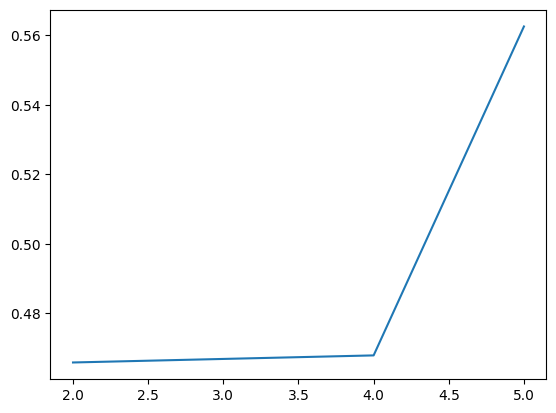

In [ ]:
import matplotlib.pyplot as plt

plt.plot(sportscar_d.groupby(['seat_1'])['choice_1'].mean())

The plot does not look as expected, I was expecting some peak in the middle and then sports cars with too many seats would not be as appealing.
In any case, it seems that the effect is not linear, more like quadratic.
Since the variable seats is discrete we coud encode it as binary dummy, one for each level, and then get the completely flexible form. We will see the quadratic for now.

We will create a new dataset witht the transformed varaible.


In [ ]:
sq_sportscar_d = sportscar_d.copy()
sq_sportscar_d['seat_1_sq'] = sportscar_d['seat_1']^2

And now we fit the model again on the new dataset

In [ ]:
logit_mod = sm.Logit(sq_sportscar_d.choice_1, sq_sportscar_d[ ['seat_1', 'seat_1_sq', 'price_1', 'trans_1_auto', 'convert_1_yes']] )
logit_res = logit_mod.fit(disp=0)

print(logit_res.summary())

                           Logit Regression Results                           
Dep. Variable:               choice_1   No. Observations:                 1310
Model:                          Logit   Df Residuals:                     1305
Method:                           MLE   Df Model:                            4
Date:                Mon, 28 Aug 2023   Pseudo R-squ.:                  0.1073
Time:                        10:38:00   Log-Likelihood:                -810.61
converged:                       True   LL-Null:                       -908.02
Covariance Type:            nonrobust   LLR p-value:                 4.867e-41
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
seat_1            1.4092      0.182      7.724      0.000       1.052       1.767
seat_1_sq        -0.5040      0.077     -6.585      0.000      -0.654      -0.354
price_1          -0.1080      0.011    -

Log likelihhood went up (as expected, one more variable), fitting seems quite better via the Pseudo R-squ.

## Exercise: Re-analyze the dataset using alternatives 1 and 3, instead of 1 and 2, and compare the differences.

Reload dataset

Change the condition we filter the dataset, keep only alternatives 1 and 3

In [ ]:
import pandas as pd

sportscar = pd.read_csv("https://raw.githubusercontent.com/pmontman/tmp_choicemodels/main/data/sportscar_choice_long.csv")
sportscar.head(5)

,resp_id,ques,alt,segment,seat,trans,convert,price,choice
0,1,1,1,basic,2,manual,yes,35,0
1,1,1,2,basic,5,auto,no,40,0
2,1,1,3,basic,5,auto,no,30,1
3,1,2,1,basic,5,manual,no,35,0
4,1,2,2,basic,2,manual,no,30,1


In [ ]:
sportscar = sportscar[sportscar['alt'].isin( [1, 3]) ]
sportscar.head()

,resp_id,ques,alt,segment,seat,trans,convert,price,choice
0,1,1,1,basic,2,manual,yes,35,0
2,1,1,3,basic,5,auto,no,30,1
3,1,2,1,basic,5,manual,no,35,0
5,1,2,3,basic,4,auto,no,35,0
6,1,3,1,basic,5,auto,yes,35,1


**From now on is similar code to the prior analysis.**


In [ ]:
sportscar = sportscar.pivot(['ques', 'resp_id'], 'alt')

<ipython-input-64-cf4d64648970>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sportscar = sportscar.pivot(['ques', 'resp_id'], 'alt')


In [ ]:
sportscar

segment        seat      trans         convert      price      \
alt                1      3    1  3       1       3       1    3     1   3   
ques resp_id                                                                 
1    1         basic  basic    2  5  manual    auto     yes   no    35  30   
     2         basic  basic    5  4  manual    auto      no  yes    35  40   
     3         basic  basic    4  5    auto    auto     yes  yes    35  40   
     4         basic  basic    2  4    auto  manual      no  yes    30  40   
     5         basic  basic    5  4    auto  manual     yes   no    35  35   
...              ...    ...  ... ..     ...     ...     ...  ...   ...  ..   
10   196       basic  basic    4  2  manual    auto     yes   no    30  30   
     197       basic  basic    2  2    auto  manual     yes  yes    40  30   
     198       basic  basic    5  4    auto    auto      no  yes    30  30   
     199       basic  basic    5  4  manual    auto     yes   no    35  35   
     200         fun    fun    4  4    auto  manual     yes   no    40  40   

             choice     
alt               1  3  
ques resp_id            
1    1            0  1  
     2            0  1  
     3            1  0  
     4            0  0  
     5            0  0  
...             ... ..  
10   196          0  1  
     197          0  1  
     198          1  0  
     199          0  0  
     200          0  0  

[2000 rows x 12 columns]

In [ ]:
sportscar.columns = ['_'.join([str(element) for element in a]) for a in sportscar.columns.to_flat_index()]

In [ ]:
sportscar = sportscar[ ~((sportscar['choice_1'] ==0) & (sportscar['choice_3'] ==0)) ]

In [ ]:
sportscar

segment_1 segment_3  seat_1  seat_3 trans_1 trans_3 convert_1  \
ques resp_id                                                                 
1    1           basic     basic       2       5  manual    auto       yes   
     2           basic     basic       5       4  manual    auto        no   
     3           basic     basic       4       5    auto    auto       yes   
     8           basic     basic       5       4  manual    auto        no   
     9           basic     basic       4       5    auto    auto        no   
...                ...       ...     ...     ...     ...     ...       ...   
10   190         basic     basic       4       5  manual  manual        no   
     192           fun       fun       4       2    auto    auto       yes   
     196         basic     basic       4       2  manual    auto       yes   
     197         basic     basic       2       2    auto  manual       yes   
     198         basic     basic       5       4    auto    auto        no   

             convert_3  price_1  price_3  choice_1  choice_3  
ques resp_id                                                  
1    1              no       35       30         0         1  
     2             yes       35       40         0         1  
     3             yes       35       40         1         0  
     8              no       40       30         1         0  
     9             yes       40       40         0         1  
...                ...      ...      ...       ...       ...  
10   190            no       35       30         0         1  
     192           yes       30       30         0         1  
     196            no       30       30         0         1  
     197           yes       40       30         0         1  
     198           yes       30       30         1         0  

[1346 rows x 12 columns]

In [ ]:
sportscar = sportscar.drop(columns=['choice_3'])
sportscar

segment_1 segment_3  seat_1  seat_3 trans_1 trans_3 convert_1  \
ques resp_id                                                                 
1    1           basic     basic       2       5  manual    auto       yes   
     2           basic     basic       5       4  manual    auto        no   
     3           basic     basic       4       5    auto    auto       yes   
     8           basic     basic       5       4  manual    auto        no   
     9           basic     basic       4       5    auto    auto        no   
...                ...       ...     ...     ...     ...     ...       ...   
10   190         basic     basic       4       5  manual  manual        no   
     192           fun       fun       4       2    auto    auto       yes   
     196         basic     basic       4       2  manual    auto       yes   
     197         basic     basic       2       2    auto  manual       yes   
     198         basic     basic       5       4    auto    auto        no   

             convert_3  price_1  price_3  choice_1  
ques resp_id                                        
1    1              no       35       30         0  
     2             yes       35       40         0  
     3             yes       35       40         1  
     8              no       40       30         1  
     9             yes       40       40         0  
...                ...      ...      ...       ...  
10   190            no       35       30         0  
     192           yes       30       30         0  
     196            no       30       30         0  
     197           yes       40       30         0  
     198           yes       30       30         1  

[1346 rows x 11 columns]

In [ ]:
sportscar_d = pd.get_dummies(sportscar)
sportscar_d.head()

seat_1  seat_3  price_1  price_3  choice_1  segment_1_basic  \
ques resp_id                                                                
1    1             2       5       35       30         0                1   
     2             5       4       35       40         0                1   
     3             4       5       35       40         1                1   
     8             5       4       40       30         1                1   
     9             4       5       40       40         0                1   

              segment_1_fun  segment_1_racer  segment_3_basic  segment_3_fun  \
ques resp_id                                                                   
1    1                    0                0                1              0   
     2                    0                0                1              0   
     3                    0                0                1              0   
     8                    0                0                1              0   
     9                    0                0                1              0   

              segment_3_racer  trans_1_auto  trans_1_manual  trans_3_auto  \
ques resp_id                                                                
1    1                      0             0               1             1   
     2                      0             0               1             1   
     3                      0             1               0             1   
     8                      0             0               1             1   
     9                      0             1               0             1   

              trans_3_manual  convert_1_no  convert_1_yes  convert_3_no  \
ques resp_id                                                              
1    1                     0             0              1             1   
     2                     0             1              0             0   
     3                     0             0              1             0   
     8                     0             1              0             1   
     9                     0             1              0             0   

              convert_3_yes  
ques resp_id                 
1    1                    0  
     2                    1  
     3                    1  
     8                    0  
     9                    1

In [ ]:
logit_mod = sm.Logit(sportscar_d.choice_1, sportscar_d[ ['seat_1', 'price_1', 'trans_1_auto', 'convert_1_yes']] )
logit_res = logit_mod.fit(disp=0)

print(logit_res.summary())

                           Logit Regression Results                           
Dep. Variable:               choice_1   No. Observations:                 1346
Model:                          Logit   Df Residuals:                     1342
Method:                           MLE   Df Model:                            3
Date:                Mon, 28 Aug 2023   Pseudo R-squ.:                 0.07734
Time:                        10:38:00   Log-Likelihood:                -860.42
converged:                       True   LL-Null:                       -932.55
Covariance Type:            nonrobust   LLR p-value:                 4.571e-31
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
seat_1            0.3000      0.044      6.796      0.000       0.213       0.387
price_1          -0.0520      0.006     -9.319      0.000      -0.063      -0.041
trans_1_auto      1.0819      0.117     